# PyKOALA Data Reduction Sequence

This notebook contains the basic reduction steps that can be done with pyKOALA for the KOALA instrument.

In [138]:
from matplotlib import pyplot as plt
import numpy as np
from koala import __version__
import warnings

# You may want to comment the following line
warnings.filterwarnings("ignore")
print("pyKOALA version: ", __version__)

pyKOALA version:  0.1.1


First, let's import a basic module to handle the RSS data:

In [139]:
from koala.koala_ifu import koala_rss

The koala_rss is a *DataContainer* that will be used to store the RSS data and track all the changes applied to it.

Now let's load some data that we have partially reduced with 2dfdr. The target will be the spectrophotometric standard star HR7596:

In [140]:
# List of RSS objects
std_star_rss = []
aaomega_arms = {'blue': 1, 'red': 2}
# Choose which arm of the spectrograph is going to be used
arm = 'blue'

for i in [23, 24, 25]:
    filename = f"data/07sep{aaomega_arms[arm]}00{i}red.fits"
    rss = koala_rss(filename)
    print(f"File {filename} corresponds to object {rss.header['OBJECT']}")
    std_star_rss.append(rss)

File data/07sep10023red.fits corresponds to object HR 7596
File data/07sep10024red.fits corresponds to object HR 7596 3S
File data/07sep10025red.fits corresponds to object HR 7596 3W


Now let us start applying some corrections to the data!

In this tutorial, we will consider the following corrections:
- Instrumental throughput
- Atmospheric extinction
- Telluric absorption
- Sky emission

Some of these corrections might not be relevant at a particular wavelength regime. For example, the blue arm of the AAOMega spectrograph 3600-5000 A is not affected by the telluric absorption.

# Corrections
## Instrumental throughput

In [141]:
from koala.corrections.throughput import Throughput
from koala.plotting.qc_plot import qc_throughput

The throughput correction accounts for the differences in the efficiency of each fibre in the instrument. This effect also depends on the wavelength that we are using.

In pyKOALA (at least version <= 0.1.1) this can be computed from a set of input rss files that correspond to flat exposures as follows

In [142]:
Throughput.create_throughput_from_flat?

In [143]:
flat_rss = [koala_rss(f"data/07sep{aaomega_arms[arm]}00{flat}red.fits") for flat in [11, 12, 13, 14]]
throughput, throughput_std = Throughput.create_throughput_from_flat(flat_rss, clear_nan=True)

We can assess the quality of our resulting throughput correction by using the built-in quality control plotting functions

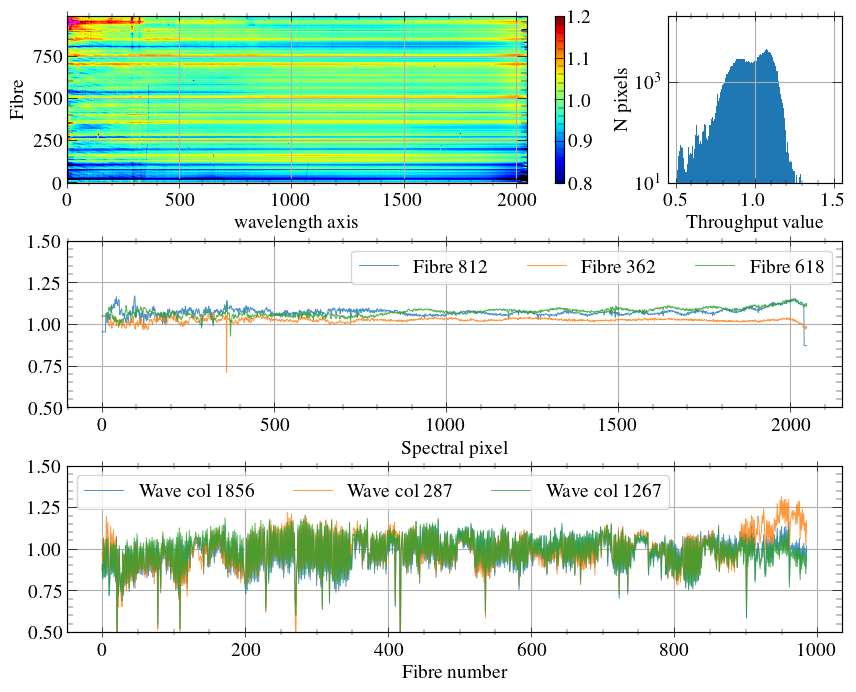

In [144]:
throughput_fig = qc_throughput(throughput)
plt.show(throughput_fig)

Now let's apply this correction to out standard star RSS. Like any correction in pyKOALA, there's an especial function to apply this correction:

In [145]:
throughput_corr = Throughput()
for i in range(len(std_star_rss)):
    std_star_rss[i] = throughput_corr.apply(throughput, std_star_rss[i])

Each correction is recorded within the `log` attribute:

In [146]:
for key, val in std_star_rss[0].log.items():
    print(f"Process *{key}* with info:\n   {val}")

Process *read* with info:
   {'comment': '- RSS read from  07sep10023red.fits', 'index': None}
Process *mask from file* with info:
   {'comment': None, 'index': 0}
Process *blue edge* with info:
   {'comment': None, 'index': 1}
Process *red edge* with info:
   {'comment': None, 'index': 2}
Process *cosmic* with info:
   {'comment': None, 'index': 3}
Process *extreme negative* with info:
   {'comment': None, 'index': 4}
Process *wavelength fix* with info:
   {'comment': None, 'index': None, 'sol': []}
Process *ThroughputCorrection* with info:
   2D throughput applied


## Atmospheric extinction

In [147]:
from koala.corrections.atmospheric_corrections import AtmosphericExtinction

AtmosphericExtinction?

In [148]:
atm_ext_corr = AtmosphericExtinction()

[Correction: AtmosphericExtinction] Initialising Atm ext. correction model.
[Correction: AtmosphericExtinction] No extinction provided
[Correction: AtmosphericExtinction] Computing extinction at airmass 1.0 based on model:
    /home/pablo/Develop/koala/src/koala/corrections/../input_data/observatory_extinction/ssoextinct.dat


In [149]:
for i in range(len(std_star_rss)):
    std_star_rss[i] = atm_ext_corr.apply(std_star_rss[i])

[Correction: AtmosphericExtinction] Applying model-based extinction correction to RSS file
[Correction: AtmosphericExtinction] Applying model-based extinction correction to RSS file
[Correction: AtmosphericExtinction] Applying model-based extinction correction to RSS file


## Telluric absorption

In [150]:
from koala.corrections.sky import Tellurics

Tellurics?

There are two ways of estimating the Tellucir correction: using a default model or using an empirical approach from the data


> Obtaining telluric correction using spectrophotometric star... 
> Obtaining telluric correction using spectrophotometric star... 
> Obtaining telluric correction using spectrophotometric star... 

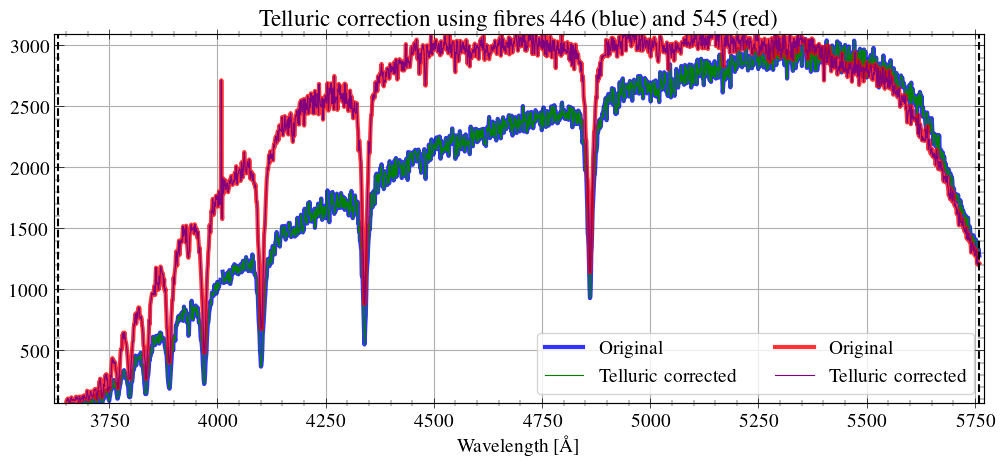

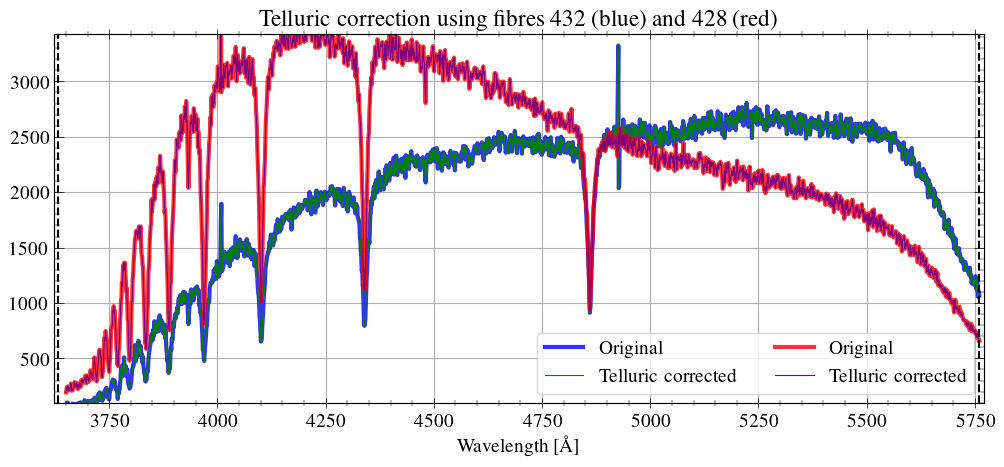

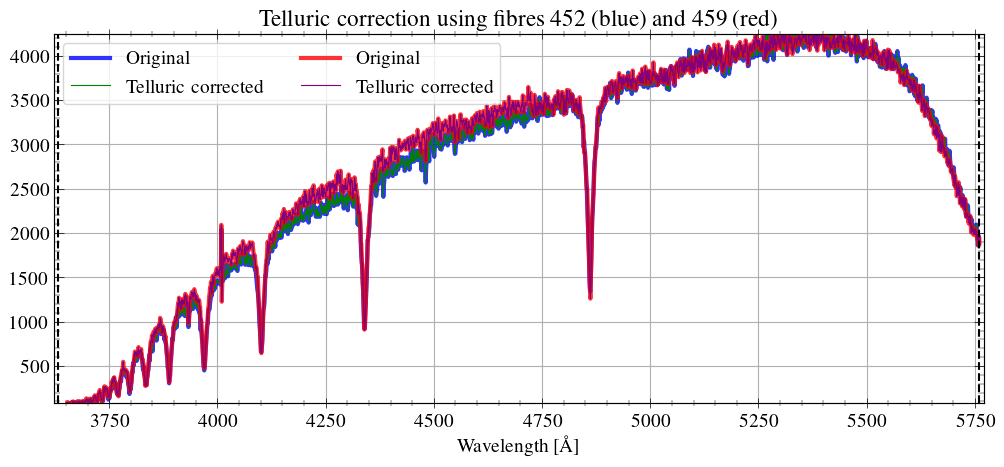

In [151]:
for i in range(len(std_star_rss)):
    telluric_correction = Tellurics(std_star_rss[i], verbose=True)
    _, fig = telluric_correction.telluric_from_model(
                plot=True, width=30)
    # Reopen the figure
    plt.figure(fig)
    
    # Apply the correction to the star
    std_star_rss[i] = telluric_correction.apply(std_star_rss[i])

## Sky emission

This is quite a broad (and difficult) correction. In particular, KOALA does not count with auxiliary sky fibres that allow to estimate the sky brightness simultaneous to the acquisition of data. Therefore, the estimation of the sky contribution must be inferred from the science exposure or from offset sky frames taken between the observing sequence. 

At present, pyKOALA provides several ways to estimate a sky emission model... See the sky emission tutorial for a more detailed discussion.

In [152]:
from koala.corrections.sky import SkyFromObject
SkyFromObject?

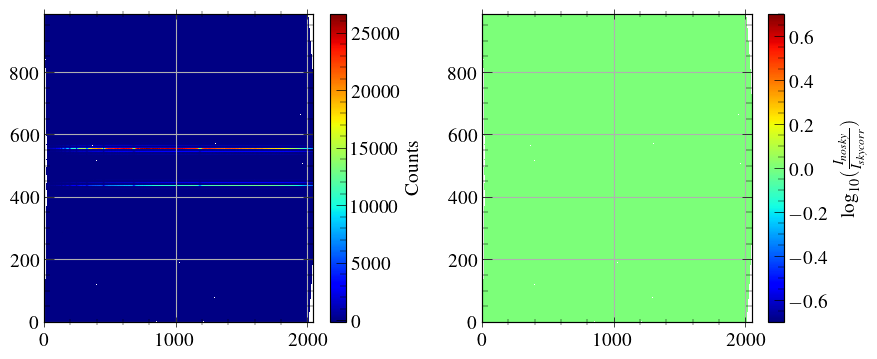

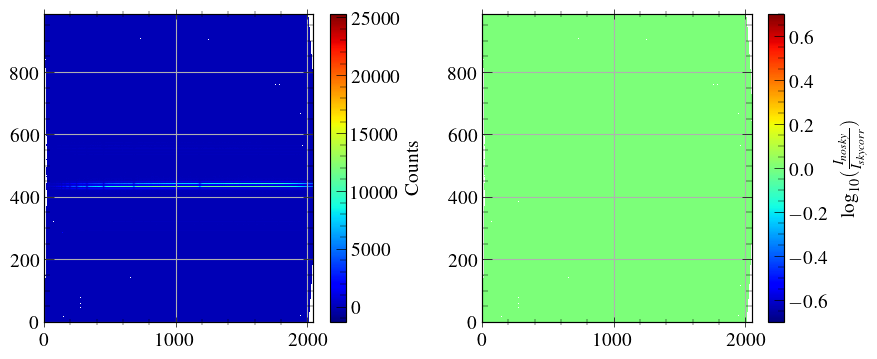

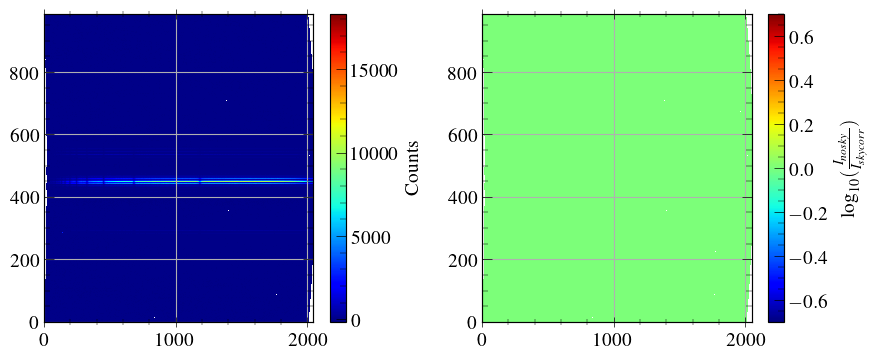

In [159]:
for i in range(len(std_star_rss)):
    skymodel = SkyFromObject(std_star_rss[i])
    pct_sky = skymodel.estimate_sky()
    # TODO: This must be included in the source code
    skymodel.intensity = pct_sky[1]
    skymodel.variance = (pct_sky[1] - pct_sky[0])**2
    
    # Store the value of the RSS intensity before substraction
    intensity_no_sky = std_star_rss[i].intensity_corrected.copy()

    std_star_rss[i] = skymodel.substract_sky(std_star_rss[i])
    
    # Compare between the two versions of the data
    fig = plt.figure(figsize=(10, 4))
    ax = fig.add_subplot(121)
    mappable = ax.imshow(std_star_rss[i].intensity_corrected,
                         origin='lower', aspect='auto',
                         interpolation='none', cmap='jet')
    plt.colorbar(mappable, ax=ax, label='Counts')
    ax = fig.add_subplot(122)
    mappable = ax.imshow(np.log10(intensity_no_sky / std_star_rss[i].intensity_corrected),
                         vmin=-0.7, vmax=.7, origin='lower', aspect='auto',
                         interpolation='none', cmap='jet')
    plt.colorbar(mappable, ax=ax, label=r'$\log_{10}(\frac{I_{nosky}}{I_{skycorr}})$')
    plt.subplots_adjust(wspace=0.3)


# Cubing

In [160]:
from koala.register.registration import register_stars
from koala.cubing import build_cube

[Registering] Registering stars through 2D-Moffat modelling.
Object:  HR 7596
[RSS] Offset-coords updated
[RSS] Centre coords (0.2734, 0.2734) updated to (0.0004, -0.0003)
Object:  HR 7596 3S
[RSS] Offset-coords updated
[RSS] Centre coords (0.2725, 0.2725) updated to (0.0002, 0.0007)
Object:  HR 7596 3W
[RSS] Offset-coords updated
[RSS] Centre coords (0.2723, 0.2723) updated to (0.0010, 0.0007)


ValueError: 'Grays_r' is not a valid value for cmap; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r'

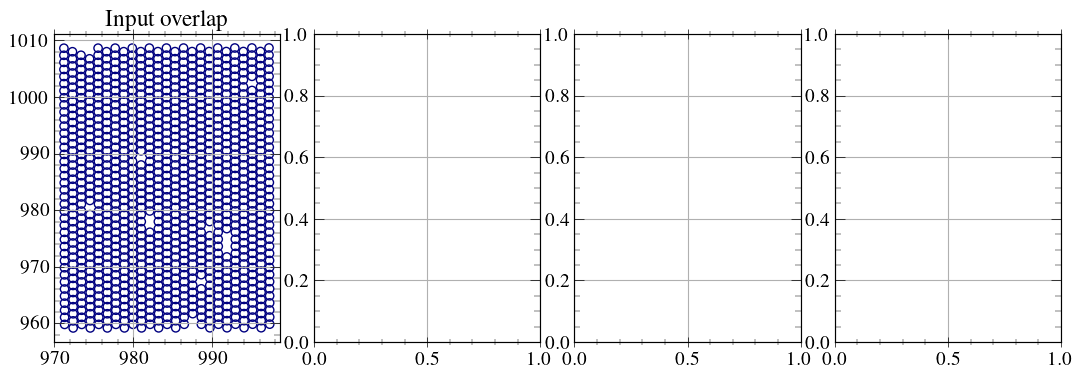

In [161]:
fig = register_stars(std_star_rss, moffat=True, plot=True)